In [2]:
#1. Importation des Bibliothèques
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Importation des 3 modèles
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

# Configuration de NLTK
try:
    stopwords.words('french')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

print("Bibliothèques et ressources prêtes.")

Bibliothèques et ressources prêtes.


In [3]:
# 2. Chargement des Données
try:
    df = pd.read_csv('cleaned_merged_jobs.csv')
    print("Fichier 'cleaned_merged_jobs.csv' chargé avec succès.")
    print(f"Dimensions du DataFrame : {df.shape}")
except FileNotFoundError:
    print("Erreur : Le fichier 'cleaned_merged_jobs.csv' est introuvable.")
    df = None

Fichier 'cleaned_merged_jobs.csv' chargé avec succès.
Dimensions du DataFrame : (2958, 12)


In [4]:
# 3. Fonction de Nettoyage du Texte
# Initialisation du stemmer et des stopwords
stemmer = SnowballStemmer('french')
stop_words = set(stopwords.words('french'))

def clean_text(text):
    """
    Fonction pour nettoyer le texte : minuscule, suppression de la ponctuation, 
    tokenisation, suppression des stopwords et stemming.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

print("Fonction 'clean_text' définie.")

Fonction 'clean_text' définie.


In [5]:
#4. Application du Nettoyage et Ingénierie des Fonctionnalités
if df is not None:
    # Remplacer les valeurs NaN par une chaîne vide
    for col in ['title', 'description']:
        df[col] = df[col].fillna('')

    # Appliquer le nettoyage
    print("Nettoyage des colonnes 'title' et 'description' en cours...")
    df['title_clean'] = df['title'].apply(clean_text)
    df['description_clean'] = df['description'].apply(clean_text)

    # Créer la colonne combinée pour le modèle
    df['combined_text'] = df['title_clean'] + ' ' + df['description_clean']
    
    print("Nettoyage et création de 'combined_text' terminés.")

Nettoyage des colonnes 'title' et 'description' en cours...
Nettoyage et création de 'combined_text' terminés.


In [6]:
# 5. Préparation des Données pour l'Entraînement
if df is not None and 'job_category' in df.columns:
    # Supprimer les lignes où la catégorie est manquante
    df.dropna(subset=['job_category'], inplace=True)
    
    # Exclure la catégorie 'Autres' pour l'entraînement
    df_model = df[df['job_category'] != 'Autres'].copy()
    
    # Définir les features (X) et la cible (y)
    X = df_model['combined_text']
    y = df_model['job_category']

    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    
    print(f"Données prêtes : {len(X_train)} échantillons d'entraînement, {len(X_test)} de test.")
else:
    print("Préparation des données annulée (DataFrame ou colonne 'job_category' non trouvé).")

Données prêtes : 2218 échantillons d'entraînement, 740 de test.


C:\Users\ALI\AppData\Local\Temp\ipykernel_10672\2529027895.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_model['job_category'], order=df_model['job_category'].value_counts().index, palette='viridis')


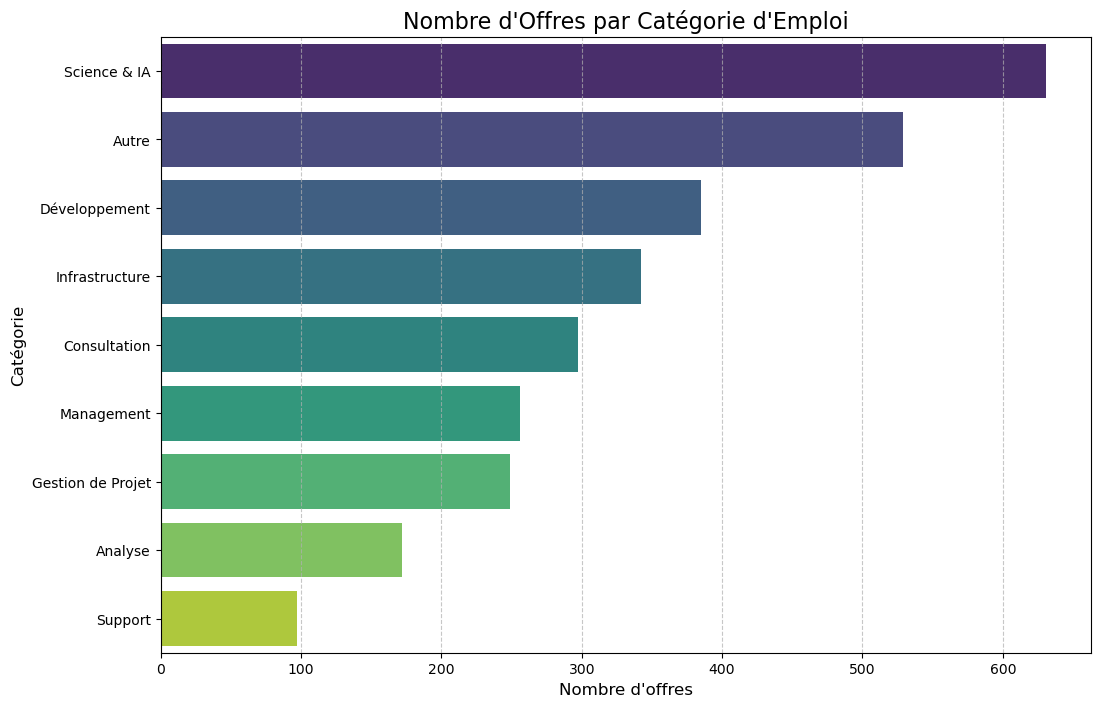

In [7]:
#6. Visualisation de la Répartition des Catégories d'Emploi
if 'df_model' in locals():
    plt.figure(figsize=(12, 8))
    sns.countplot(y=df_model['job_category'], order=df_model['job_category'].value_counts().index, palette='viridis')
    plt.title("Nombre d'Offres par Catégorie d'Emploi", fontsize=16)
    plt.xlabel("Nombre d'offres", fontsize=12)
    plt.ylabel("Catégorie", fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

In [8]:
#7. Entraînement et Évaluation des Modèles
if 'X_train' in locals():
    # Définition des modèles
    models = {
        "Régression Logistique": LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear'),
        "Machine à Vecteurs de Support (SVC)": LinearSVC(random_state=42, dual=True), # dual=True pour éviter une erreur avec certaines versions
        "Naive Bayes Multinomial": MultinomialNB()
    }
    
    # Dictionnaire pour stocker les résultats
    results = {}

    # Boucle d'entraînement et d'évaluation
    for model_name, model in models.items():
        print(f"\n==================== {model_name.upper()} ====================")
        
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
            ('clf', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        results[model_name] = {'accuracy': accuracy, 'pipeline': pipeline}
        
        print(f"Accuracy : {accuracy:.4f}")
        print("\nRapport de Classification :")
        print(classification_report(y_test, y_pred))


==================== RÉGRESSION LOGISTIQUE ====================
Accuracy : 0.9041

Rapport de Classification :
                   precision    recall  f1-score   support

          Analyse       1.00      0.84      0.91        43
            Autre       0.89      0.89      0.89       133
     Consultation       0.94      0.86      0.90        74
    Développement       0.95      0.92      0.93        96
Gestion de Projet       0.98      0.97      0.98        62
   Infrastructure       0.99      0.91      0.95        86
       Management       0.97      0.94      0.95        64
     Science & IA       0.77      0.93      0.84       158
          Support       1.00      0.71      0.83        24

         accuracy                           0.90       740
        macro avg       0.94      0.88      0.91       740
     weighted avg       0.91      0.90      0.91       740


==================== MACHINE À VECTEURS DE SUPPORT (SVC) ====================


C:\Program Files\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy : 0.9351

Rapport de Classification :
                   precision    recall  f1-score   support

          Analyse       0.90      0.88      0.89        43
            Autre       0.91      0.94      0.92       133
     Consultation       0.96      0.91      0.93        74
    Développement       0.94      0.97      0.95        96
Gestion de Projet       0.98      1.00      0.99        62
   Infrastructure       0.98      0.97      0.97        86
       Management       0.94      0.94      0.94        64
     Science & IA       0.92      0.92      0.92       158
          Support       0.90      0.79      0.84        24

         accuracy                           0.94       740
        macro avg       0.94      0.92      0.93       740
     weighted avg       0.94      0.94      0.93       740


==================== NAIVE BAYES MULTINOMIAL ====================
Accuracy : 0.8622

Rapport de Classification :
                   precision    recall  f1-score   support

         

C:\Users\ALI\AppData\Local\Temp\ipykernel_10672\1181036613.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  splot = sns.barplot(x=model_names, y=accuracies, palette='rocket')


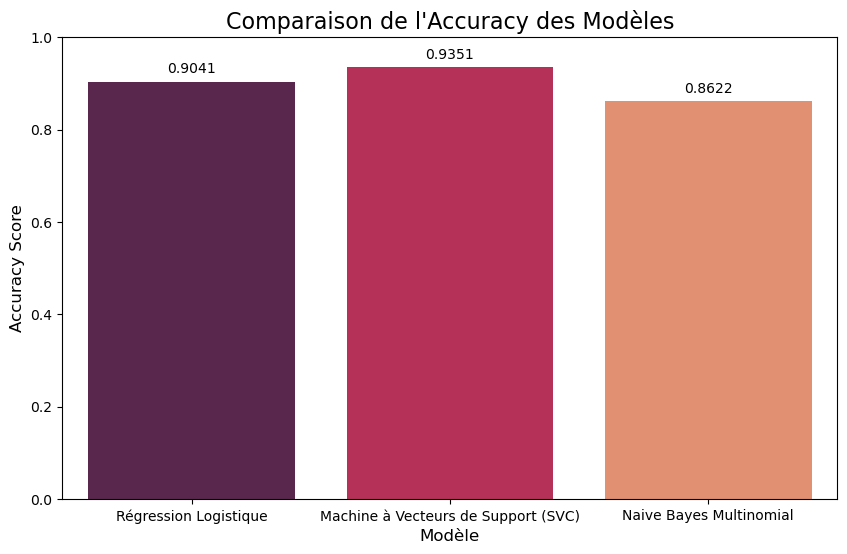

In [9]:
#8. Comparaison Visuelle des Performances des Modèles
if 'results' in locals() and results:
    # Extraire les noms et les scores d'accuracy
    model_names = list(results.keys())
    accuracies = [res['accuracy'] for res in results.values()]

    plt.figure(figsize=(10, 6))
    splot = sns.barplot(x=model_names, y=accuracies, palette='rocket')

    # Ajouter les valeurs sur les barres
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.4f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

    plt.title("Comparaison de l'Accuracy des Modèles", fontsize=16)
    plt.xlabel("Modèle", fontsize=12)
    plt.ylabel("Accuracy Score", fontsize=12)
    plt.ylim(0, 1) # L'accuracy est toujours entre 0 et 1
    plt.show()

In [10]:
#9. Sauvegarde du Meilleur Modèle
if 'results' in locals() and results:
    # Trouver le meilleur modèle
    best_model_name = max(results, key=lambda name: results[name]['accuracy'])
    best_model_pipeline = results[best_model_name]['pipeline']
    best_accuracy = results[best_model_name]['accuracy']

    print(f"=> Le meilleur modèle est '{best_model_name}' avec une accuracy de {best_accuracy:.4f}.")

    # Sauvegarder le pipeline du meilleur modèle
    model_filename = 'best_job_classification_model.joblib'
    joblib.dump(best_model_pipeline, model_filename)
    print(f"Meilleur modèle sauvegardé sous le nom : {model_filename}")

=> Le meilleur modèle est 'Machine à Vecteurs de Support (SVC)' avec une accuracy de 0.9351.
Meilleur modèle sauvegardé sous le nom : best_job_classification_model.joblib


In [ ]:
#10. Test de Prédiction avec le Meilleur Modèle
# Définir la fonction de prédiction
def get_job_category_prediction(title, description, model):
    combined_text = clean_text(title + " " + description)
    return model.predict([combined_text])[0]

# Tester la prédiction
if 'best_model_name' in locals():
    print("\n--- Test de Prédiction sur une Offre Inédite ---")
    
    test_job_title = "Développeur Python Django"
    test_job_description = "Recherche d'un développeur backend pour maintenir et faire évoluer des applications web. Maîtrise de Python, Django et REST APIs requise."
    
    try:
        # Charger le meilleur modèle
        final_model = joblib.load('best_job_classification_model.joblib')
        
        # Obtenir la prédiction
        predicted_category = get_job_category_prediction(test_job_title, test_job_description, final_model)
        
        print(f"\nOffre d'emploi : '{test_job_title}'")
        print(f"Description : '{test_job_description}'")
        print(f"-> Catégorie Prédite par '{best_model_name}' : {predicted_category}")

    except FileNotFoundError:
        print("Fichier modèle non trouvé. Veuillez exécuter la cellule de sauvegarde.")
    except Exception as e:
        print(f"Une erreur est survenue : {e}")


--- Test de Prédiction sur une Offre Inédite ---

Offre d'emploi : 'Développeur Python Django'
Description : 'Recherche d'un développeur backend pour maintenir et faire évoluer des applications web. Maîtrise de Python, Django et REST APIs requise.'
-> Catégorie Prédite par 'Machine à Vecteurs de Support (SVC)' : Développement
